<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/iula_blurr_highapi_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq transformers tqdm
!pip install -Uqq ohmeow-blurr

     |████████████████████████████████| 2.6 MB 8.6 MB/s 
     |████████████████████████████████| 76 kB 5.9 MB/s 
     |████████████████████████████████| 636 kB 68.8 MB/s 
     |████████████████████████████████| 895 kB 77.3 MB/s 
     |████████████████████████████████| 3.3 MB 60.3 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 264 kB 12.6 MB/s 
     |████████████████████████████████| 188 kB 13.5 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 1.2 MB 14.3 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 243 kB 41.7 MB/s 
     |████████████████████████████████| 118 kB 51.1 MB/s 


In [2]:
import os
import glob
import pandas as pd

from blurr.modeling.core import BlearnerForSequenceClassification

from fastai.text.all import *

### Leer Corpus

In [3]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,label,sentence,is_valid
0,economía,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,economía,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,economía,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,economía,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,economía,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...
52350,medicina,Diarrea.,True
52351,medicina,Debilidad.,False
52352,medicina,Gusto alterado.,False
52353,medicina,Parestesias peribucales.,False


### Modelar

In [4]:

# pretrained_model_name = "distilbert-base-uncased"
# pretrained_model_name = "bert-base-uncased"
pretrained_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# pretrained_model_name = "distilroberta-base"

In [5]:
dl_kwargs = {'bs': 4, 'val_bs': 8}
learn_kwargs = { 'metrics': [F1Score(average=None)] }

learn = BlearnerForSequenceClassification.from_dataframe(
    co_df, pretrained_model_name, 
    text_attr='sentence', label_attr='label',
    dblock_splitter=ColSplitter(),
    dl_kwargs=dl_kwargs, learner_kwargs=learn_kwargs)

learn = learn.to_fp16()


Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [6]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 228 x 768       
Embedding                                 81315072   False     
Embedding                                 393216     False     
Embedding                                 1536       False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.002511886414140463)

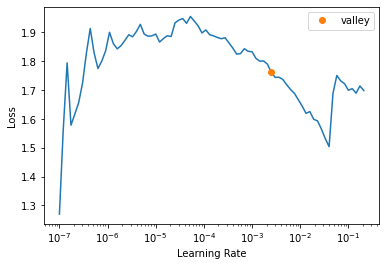

In [7]:
learn.lr_find()

In [8]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,f1_score,time
0,0.266847,0.241150,[0.80652963 0.81857348 0.83695652 0.94404164 0.9170529 ],07:24


In [9]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"quedan reservadas, en todo caso, a las fuerzas y cuerpos de seguridad del estado bajo la dependencia del gobierno los servicios policiales de caracter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de espanoles y extranjeros, regimen general de extranjeria, extradicion y expulsion, emigracion e inmigracion, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del estado, contrabando y fraude fiscal y las demas funciones que directamente les encomienda el articulo 104 de la constitucion [ 19 ] y las que les atribuya la ley organica que lo desarrolle.",legal,legal
1,"tal cosa se debe a que ; en periodo corto, los salarios nominales descendentes y los reales ascendentes son, cada uno de ellos por razones privativas, fenomenos ligados a la baja de la ocupacion, pues aunque los obreros estan mas dispuestos a aceptar reducciones en su remuneracion al bajar el empleo, los salarios reales suben inevitablemente, en las mismas circunstancias, debido al mayor rendimiento marginal de un determinado equipo de capital, cuando la produccion disminuye.",economía,economía
2,"c si el numero de operaciones realizadas para un vencimiento no alcanzara al doble de las cantidades establecidas en los apartados a ) y b ) anteriores, el precio al cierre sera el que resulte de la media entre el mejor precio de oferta y el mejor precio de demanda al cierre y si no hubiera mejor precio de oferta y demanda o faltara uno de ellos, se tomara el precio de cierre de la sesion anterior.",economía,economía
3,"aunque es mucho lo que ya sabemos de las bases geneticas de la proliferacion celular incontrolada, apenas conocemos los rudimentos de los genes mutantes que contribuyen a los estadios posteriores del desarrollo tumoral, en particular de los que permiten a las celulas tumorales atraer a los vasos sanguineos para nutrirse, para invadir los tejidos adyacentes y para llevar a cabo la metastasis.",medicina,medicina
4,"[ 13 ] el lector puede convencerse facilmente de este punto echando un vistazo a la "" classified bibliography of articles on business cycle theory "" del profesor h. m. somers, publicada en apendice al volumen readings in business - cycle theory, al que ya nos hemos referido, o a otras bibliografias alli citadas ( pag. 444 ), particularmente la del profesor r. a. gordon.",economía,economía


### Evaluar

In [10]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.80652963, 0.81857348, 0.83695652, 0.94404164, 0.9170529 ]),
 'loss': 0.2411499172449112}

In [11]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(0.2411) TensorBase(0.9117)


### Infererir

In [12]:
learn.export('iula_learner.pkl')

In [13]:
inf_learn = load_learner('iula_learner.pkl')

In [14]:
inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
    {'sentence': 'Altos niveles de CO2 durante la calima.'},
    {'sentence': 'Las partículas de 20 micrones pueden producir neumonías.'},
]))

[(('economía',),
  (#1) [tensor(1)],
  (#1) [tensor([1.1698e-01, 8.7473e-01, 2.6230e-04, 5.0351e-03, 2.9853e-03])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([1.9859e-04, 2.6482e-04, 5.0272e-05, 9.9857e-01, 9.1515e-04])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([2.0946e-01, 1.6113e-02, 6.2217e-04, 7.5153e-01, 2.2274e-02])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([1.5391e-03, 7.5132e-05, 2.7073e-05, 9.9512e-01, 3.2419e-03])])]